In [ ]:
import logging

import numpy as np
import scipy.stats
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


Generate some data:

In [2]:
from batchglm.api.models.nb_glm import Simulator

sim = Simulator(num_observations=2000, num_features=2000)
sim.generate_sample_description(num_batches=0, num_confounders=0)
sim.generate()

random_sample_description = pd.DataFrame({
    "condition": np.random.randint(2, size=sim.num_observations)
})


Run differential expression test:

In [3]:
logging.getLogger("tensorflow").setLevel(logging.WARNING)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

import diffxpy as de


test = de.test_lrt(
    data=sim.X,
    full_formula="~ 1 + condition",
    reduced_formula="~ 1",
    sample_description=random_sample_description
)


Estimating model...
Using closed-form MLE initialization for mean
Using closed-form MME initialization for dispersion
From /home/hoelzlwimmerf/Masterarbeit/TensorFlow/batchglm/batchglm/train/tf/nb_glm/estimator.py:371: batch_and_drop_remainder (from tensorflow.contrib.data.python.ops.batching) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.batch(..., drop_remainder=True)`.
From /home/hoelzlwimmerf/Masterarbeit/TensorFlow/batchglm/batchglm/train/tf/nb/util.py:46: NegativeBinomial.__init__ (from tensorflow.contrib.distributions.python.ops.negative_binomial) is deprecated and will be removed after 2018-10-01.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Beginning with training sequence #1
Training sequence #1 complete
Estimating model rea

In [7]:
full_model = test.full_estim
reduced_model = test.reduced_estim

ll_full = np.sum(full_model.log_probs(), axis=0)
ll_reduced = np.sum(reduced_model.log_probs(), axis=0)
np.where(ll_full < ll_reduced)
delta_df = 2 * (ll_full - ll_reduced)

expected_dist = scipy.stats.chi2(full_model.design_loc.shape[-1] - reduced_model.design_loc.shape[-1])


/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


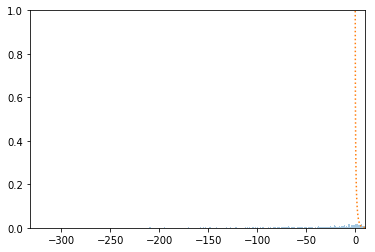

In [8]:
fig, ax = plt.subplots()
sns.distplot(delta_df, norm_hist=True, kde=False, bins=1000, ax=ax)

xmin = np.min(delta_df)
xmax = 10.
ymax = 1.
ax.set_xlim(xmin, xmax)
ax.set_ylim(top=ymax)

x = np.arange(0, xmax, xmax / 2000)
ax.plot(x, expected_dist.pdf(x), label='chi²', linestyle=":")
# ax.set_xscale("log")

plt.show()
plt.close()

